In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Download data from MTA

In [2]:
# Load data for the month of June
url1 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt"
url2 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt"
url3 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt"
url4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt"
url5 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190629.txt"
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)
df3 = pd.read_csv(url3)
df4 = pd.read_csv(url4)
df5 = pd.read_csv(url5)

In [124]:
df = pd.concat([df1, df2, df3, df4, df5])

In [125]:
# get rid of extra strings in columns 
df.columns = df.columns.str.replace(" ", "")

In [126]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
count1 = df.count()[0]
df.describe()

ENTRIES          EXITS
count    1027180.000    1027180.000
mean    42073092.644   34377301.295
std    213717105.321  196474576.462
min            0.000          0.000
25%       298971.000     119183.000
50%      2137858.500    1222591.500
75%      6745217.500    4591467.000
max   2129289036.000 2124055240.000

### Calculate number of people in and out from cummulative values

In [127]:
# Use diff() to derrive the actual number of people from the culmulative value for entries and exits for each SCP
# abs() is used to account for the turnstiles that count backwards
df['people_in'] = df.groupby(['STATION', 'UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff().abs())
df['people_out'] = df.groupby(['STATION', 'UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff().abs())

In [128]:
# show which rows are NaN - each nan is at the beginning of a new scp
df[df['people_in'].isna()].head()

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0    A002  R051  02-00-00   59 ST  NQR456W      BMT  05/25/2019  00:00:00   
42   A002  R051  02-00-01   59 ST  NQR456W      BMT  05/25/2019  00:00:00   
84   A002  R051  02-03-00   59 ST  NQR456W      BMT  05/25/2019  00:00:00   
126  A002  R051  02-03-01   59 ST  NQR456W      BMT  05/25/2019  00:00:00   
168  A002  R051  02-03-02   59 ST  NQR456W      BMT  05/25/2019  00:00:00   

        DESC  ENTRIES    EXITS  people_in  people_out  
0    REGULAR  7071830  2396411        nan         nan  
42   REGULAR  6298050  1412557        nan         nan  
84   REGULAR  1236982  4651756        nan         nan  
126  REGULAR  1115712  1720977        nan         nan  
168  REGULAR  6200254  8353543        nan         nan

In [129]:
# Remove all nan data
df = df.dropna()

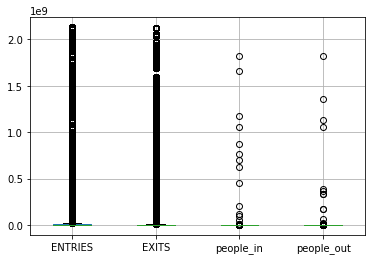

In [130]:
df.boxplot()

### Remove Outliers

In [131]:
# IQR
Q1 = df['people_out'].quantile(0.25)
Q3 = df['people_out'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

157.0


In [132]:
high_outliers = Q3 + 2 * IQR
high_outliers

480.0

In [133]:
df = df.loc[df['people_out'] < high_outliers]
count2 = df.count()[0]
df.describe()

ENTRIES          EXITS  people_in  people_out
count     956177.000     956177.000 956177.000  956177.000
mean    41566337.653   33166446.255    162.125      90.178
std    211996738.326  192398688.940    989.111     109.877
min            0.000          0.000      0.000       0.000
25%       279404.000     100204.000      8.000       7.000
50%      2059539.000    1091687.000     63.000      45.000
75%      6581493.000    4116682.000    216.000     134.000
max   2129288981.000 2124055172.000 851501.000     479.000

In [134]:
count2/count1

0.9308757958682996

### Incorporate Jieun's analysis and select only the top 30 stations

In [135]:
# list of top 30 stations from Jieun's notebook
stations = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '59 ST', '14 ST', '125 ST',
       '104 ST', 'TIMES SQ-42 ST', 'DEKALB AV', '86 ST', 'FRANKLIN AV',
       '145 ST', '167 ST', 'LEXINGTON AV/53', '72 ST', 'GUN HILL RD',
       'BOWLING GREEN', 'FULTON ST', 'GRD CNTRL-42 ST', '66 ST-LINCOLN',
       'KINGS HWY', 'GRAND ST', 'KINGSBRIDGE RD', '34 ST-PENN STA',
       'CHAMBERS ST', 'FORDHAM RD', '116 ST', '96 ST', '50 ST',
       'FT HAMILTON PKY']

In [136]:
# select only top 30 stations from data frame
df = df[df['STATION'].isin(stations)]

### Filter stations that are in Silicon Alley

In [137]:
# Load table of silicon alley stations
silicon_alley = pd.read_csv('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/data/silicon_alley.csv')

In [114]:
silicon_alley_str = silicon_alley.name

In [138]:
# we use this code to test whether stations in our top 30 are in sillicon alley
silicon_alley_str[silicon_alley_str.str.contains('Hamilton', regex=True)]

Series([], Name: name, dtype: object)

In [139]:
# filter top 30 based on stations that are in silicon alley
top_12_sa = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '14 ST', 'TIMES SQ-42 ST', 'BOWLING GREEN',
             'FULTON ST', 'GRD CNTRL-42 ST', 'GRAND ST', '34 ST-PENN STA', 'CHAMBERS ST', '50 ST']
df = df[df['STATION'].isin(top_12_sa)]

In [140]:
df['STATION'].unique()

array(['TIMES SQ-42 ST', '23 ST', 'CANAL ST', 'CHAMBERS ST', 'FULTON ST',
       '50 ST', 'GRAND ST', '42 ST-PORT AUTH', '34 ST-PENN STA', '14 ST',
       'BOWLING GREEN', 'GRD CNTRL-42 ST'], dtype=object)

### Make Graphs showing frequency for time of day and day of week 

In [141]:
# Create a day of week column
df['DATE'] = pd.to_datetime(df['DATE'])
df['weekday'] = df['DATE'].dt.day_name()

In [142]:
# Remove Saturday and Sunday - we want to target commuters and street teams don't want to work on the weekend
df = df[~df['weekday'].isin(['Saturday', 'Sunday'])]

In [143]:
heat_df = df.filter(['weekday','STATION','people_out'], axis=1)
heat_df.head()

weekday         STATION  people_out
2507  Monday  TIMES SQ-42 ST     214.000
2508  Monday  TIMES SQ-42 ST      41.000
2509  Monday  TIMES SQ-42 ST      91.000
2510  Monday  TIMES SQ-42 ST     424.000
2511  Monday  TIMES SQ-42 ST     444.000

In [144]:
heat_df = heat_df.pivot_table(index='weekday', columns='STATION', values='people_out', aggfunc='sum')

No handles with labels found to put in legend.


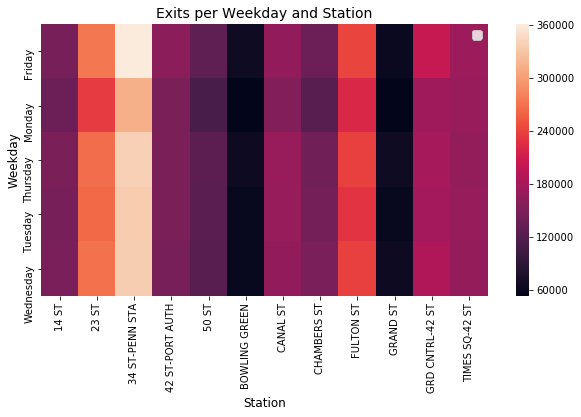

In [145]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.heatmap(heat_df)
plt.title('Exits per Weekday and Station', size=14)
plt.xlabel('Station', size=12)
plt.ylabel('Weekday', size=12)
plt.legend(fontsize=12);
plt.savefig('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/images/station_heat_map.svg')

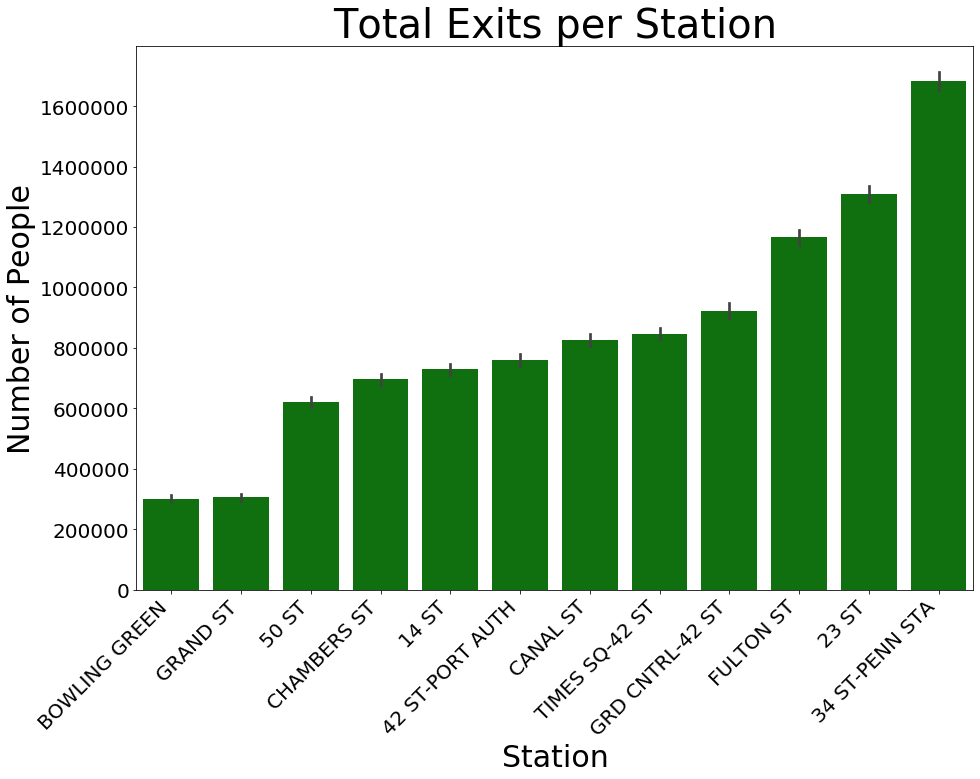

In [152]:
bar_df = df.filter(['STATION','people_out'], axis=1)
bar_df.head()
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=(a4_dims))
result = df.groupby(["STATION"])['people_out'].aggregate(np.sum).reset_index().sort_values('people_out')
total_people = sns.barplot(x = 'STATION', y='people_out', color='g', data=bar_df, estimator=sum, order=result['STATION']);
plt.title('Total Exits per Station', size=40)
plt.xlabel('Station', size=30)
plt.ylabel('Number of People', size=30)
plt.savefig('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/images/total_people.png')
total_people.set_xticklabels(total_people.get_xticklabels(), rotation=45, size=20, horizontalalignment='right')
total_people.set_yticklabels(total_people.get_yticklabels(), size=20);

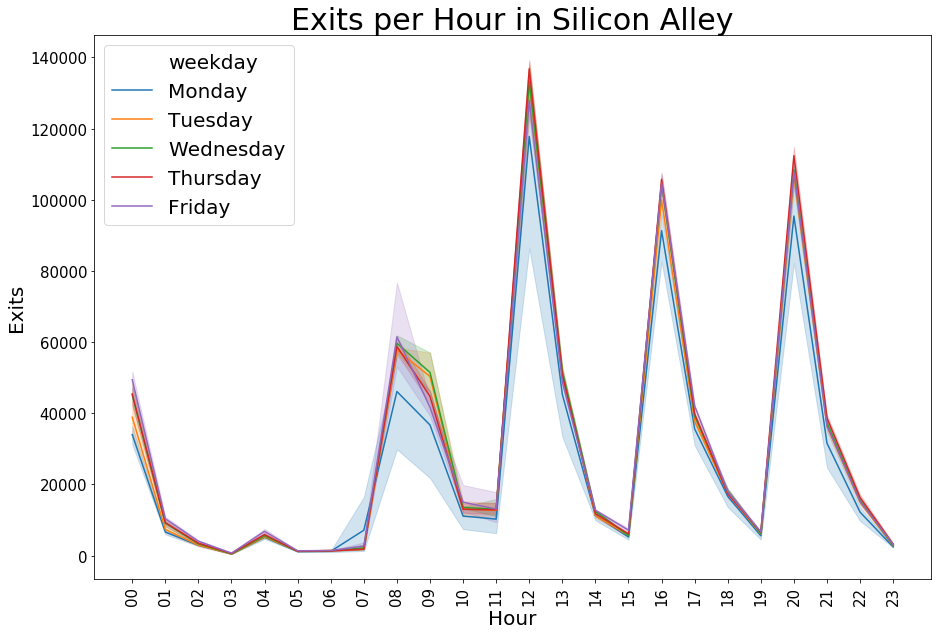

In [123]:
# Graph of time of day
df['hour'] = df['TIME'].astype(str).str[:2]

# Sort for presentation's sake
data = df[['DATE', 'hour', 'weekday', 'people_out']].groupby(
    ['DATE', 'weekday', 'hour'], as_index=False).sum()
data.sort_values(by=['hour', 'DATE', 'weekday'], inplace=True)
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.lineplot(ax=ax, x='hour', y='people_out', hue='weekday', data=data)
plt.xticks(rotation='vertical', size=15)
plt.yticks(size=15)
plt.title('Exits per Hour in Silicon Alley', size=30)
plt.xlabel('Hour', size=20)
plt.ylabel('Exits', size=20)
plt.legend(fontsize=20)
plt.savefig('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/images/time_of_day.jpg')

### Map

In [37]:
# Load shapefile using geopandas
import geopandas as gpd
import contextily as ctx

In [38]:
fp = "/Users/AuerPower/Metis/git/NYC_turnstile_EDA/data/silicon_alley3.shp"
map_df = gpd.read_file(fp)

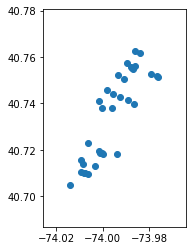

In [39]:
map_df.plot()

In [40]:
map_df.name.unique()

array(['Canal St', '50th St', 'Grand Central - 42nd St',
       'Times Sq - 42nd St', '23rd St', '34th St - Penn Station',
       'Fulton St', 'Chambers St', '42nd St - Port Authority Bus Term',
       'Bowling Green', 'Grand St', '14th St'], dtype=object)

In [41]:
map_df_stations = map_df.name

In [42]:
# select only top 30 stations from data frame
map_df_stations[map_df_stations.str.contains('Grand', regex=True)]

2     Grand Central - 42nd St
4     Grand Central - 42nd St
10    Grand Central - 42nd St
27                   Grand St
Name: name, dtype: object

In [43]:
map_df_station_names = ['Times Sq - 42nd St', '23rd St', 'Chambers St', 'Fulton St',
                        '50th St','Grand St','42nd St - Port Authority Bus Term', 'Canal St', 
                        'Grand Central - 42nd St', '34th St - Penn Station', 
                       '14th St', 'Bowling Green']

In [ ]:
len(map_df_station_names)

In [44]:
map_df = map_df[map_df['name'].isin(map_df_station_names)]

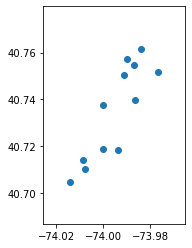

In [45]:
# remove duplicate station locations
map_df = map_df.drop_duplicates(subset='name', keep="first")
map_df.plot()

In [46]:
# Sort names so we can repalce them with the df names
map_df = map_df.sort_values(by='name')
map_df.name

31                              14th St
6                               23rd St
12               34th St - Penn Station
16    42nd St - Port Authority Bus Term
1                               50th St
25                        Bowling Green
0                              Canal St
15                          Chambers St
14                            Fulton St
2               Grand Central - 42nd St
27                             Grand St
3                    Times Sq - 42nd St
Name: name, dtype: object

In [47]:
df = df.sort_values(by='STATION')
df.STATION.unique()

array(['14 ST', '23 ST', '34 ST-PENN STA', '42 ST-PORT AUTH', '50 ST',
       'BOWLING GREEN', 'CANAL ST', 'CHAMBERS ST', 'FULTON ST',
       'GRAND ST', 'GRD CNTRL-42 ST', 'TIMES SQ-42 ST'], dtype=object)

In [48]:
# change station names in df to match map_df
map_df['name'] = map_df['name'].replace('14th St', '14 ST')
map_df['name'] = map_df['name'].replace('23rd St', '23 ST')
map_df['name']= map_df['name'].replace('34th St - Penn Station', '34 ST-PENN STA')
map_df['name'] = map_df['name'].replace('42nd St - Port Authority Bus Term', '42 ST-PORT AUTH')
map_df['name'] = map_df['name'].replace('50th St', '50 ST')
map_df['name'] = map_df['name'].replace('Bowling Green', 'BOWLING GREEN')
map_df['name'] = map_df['name'].replace('Canal St', 'CANAL ST')
map_df['name'] = map_df['name'].replace('Chambers St', 'CHAMBERS ST')
map_df['name'] = map_df['name'].replace('Fulton St', 'FULTON ST')
map_df['name'] = map_df['name'].replace('Grand Central - 42nd St', 'GRD CNTRL-42 ST')
map_df['name'] = map_df['name'].replace('Grand St', 'GRAND ST')
map_df['name'] = map_df['name'].replace('Times Sq - 42nd St', 'TIMES SQ-42 ST')

In [49]:
map_df.name

31              14 ST
6               23 ST
12     34 ST-PENN STA
16    42 ST-PORT AUTH
1               50 ST
25      BOWLING GREEN
0            CANAL ST
15        CHAMBERS ST
14          FULTON ST
2     GRD CNTRL-42 ST
27           GRAND ST
3      TIMES SQ-42 ST
Name: name, dtype: object

In [50]:
merged = map_df.set_index('name').join(df.set_index('STATION'))
merged.head()

line                                  notes  objectid  \
14 ST  1-2-3  1,2-all times, 3-all times exc nights   439.000   
14 ST  1-2-3  1,2-all times, 3-all times exc nights   439.000   
14 ST  1-2-3  1,2-all times, 3-all times exc nights   439.000   
14 ST  1-2-3  1,2-all times, 3-all times exc nights   439.000   
14 ST  1-2-3  1,2-all times, 3-all times exc nights   439.000   

                                     url                    geometry   C/A  \
14 ST  http://web.mta.info/nyct/service/  POINT (-74.00020 40.73783)  R127   
14 ST  http://web.mta.info/nyct/service/  POINT (-74.00020 40.73783)  R128   
14 ST  http://web.mta.info/nyct/service/  POINT (-74.00020 40.73783)  R128   
14 ST  http://web.mta.info/nyct/service/  POINT (-74.00020 40.73783)  R128   
14 ST  http://web.mta.info/nyct/service/  POINT (-74.00020 40.73783)  R128   

       UNIT       SCP LINENAME DIVISION       DATE      TIME     DESC  \
14 ST  R105  00-03-02   123FLM      IRT 2019-05-27  00:00:00  REGULAR   
14 ST  R105  01-06-00   123FLM      IRT 2019-06-25  20:00:00  REGULAR   
14 ST  R105  01-06-00   123FLM      IRT 2019-06-25  16:00:00  REGULAR   
14 ST  R105  01-06-00   123FLM      IRT 2019-06-25  12:00:00  REGULAR   
14 ST  R105  01-06-00   123FLM      IRT 2019-06-25  08:00:00  REGULAR   

        ENTRIES    EXITS  people_in  people_out  weekday hour  
14 ST  11065231  7464272    262.000     113.000   Monday   00  
14 ST   6606257  2365608    364.000     323.000  Tuesday   20  
14 ST   6605893  2365285    193.000     191.000  Tuesday   16  
14 ST   6605700  2365094    247.000     129.000  Tuesday   12  
14 ST   6605453  2364965     36.000      24.000  Tuesday   08

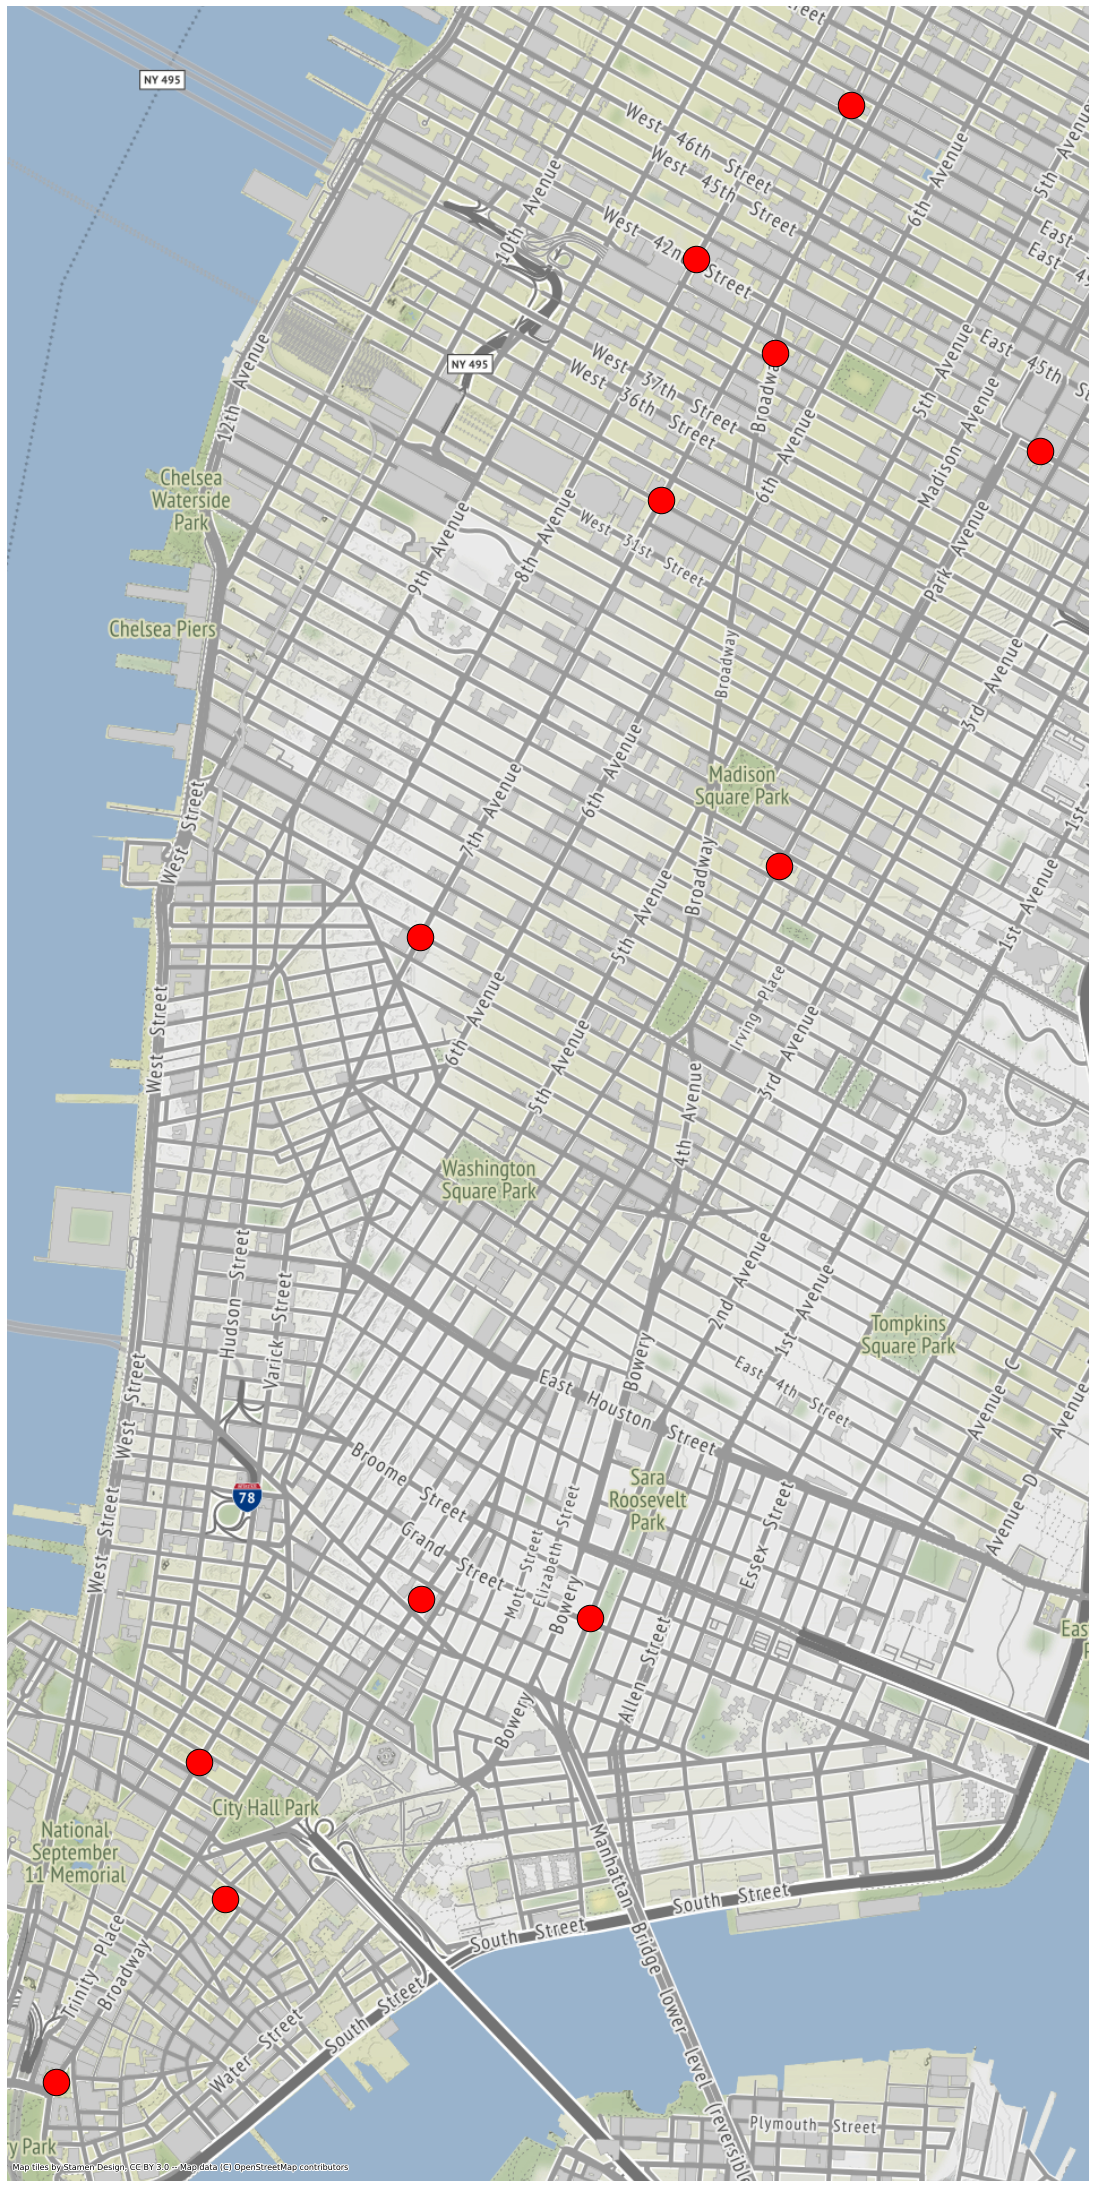

In [51]:
map_df = map_df.to_crs(epsg=3857)
ax = map_df.plot(color = "r", markersize=700, figsize=(40, 40), edgecolor='k') #alpha=0.5
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=15)
ax.set_axis_off()